In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB1,Xception,InceptionV3,ResNet50,VGG16,ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop,Adam,SGD
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, BatchNormalization,Dropout,Flatten,Input
from tensorflow.keras import Sequential

# Prepare Dataset

In [2]:
data_train = pd.read_csv('/kaggle/input/my-seminar-dataset/data_train.csv')
data_valid = pd.read_csv('/kaggle/input/my-seminar-dataset/data_valid.csv')
data_test = pd.read_csv('/kaggle/input/my-seminar-dataset/data_test.csv')

#shuffling datasets
data_train = data_train.sample(frac = 1,ignore_index = True)
data_test = data_valid.sample(frac = 1,ignore_index = True)
data_valid = data_valid.sample(frac = 1,ignore_index = True)


df = [data_train,
#       data_test,
      data_valid]
for f in df:
    print(f.shape)
    display(f.head(3))

(1454, 8)


,img,healthy,leaf_rust,powdery_mildew,seedlings,septoria,stem_rust,yellow_rust
0,8d1f0e1c0c187767.jpg,0,0,0,0,0,0,1
1,ffffffe100000000.jpg,1,0,0,0,0,0,0
2,ffffffe300000000.jpg,0,0,0,0,1,0,0


(480, 8)


,img,healthy,leaf_rust,powdery_mildew,seedlings,septoria,stem_rust,yellow_rust
0,b0f05818b8f8f87c.jpg,0,0,0,0,0,0,1
1,2e2b3e3f7cfcfcfc.jpg,0,0,0,0,0,0,1
2,79f6e2484142e378.jpg,0,0,0,0,0,1,0


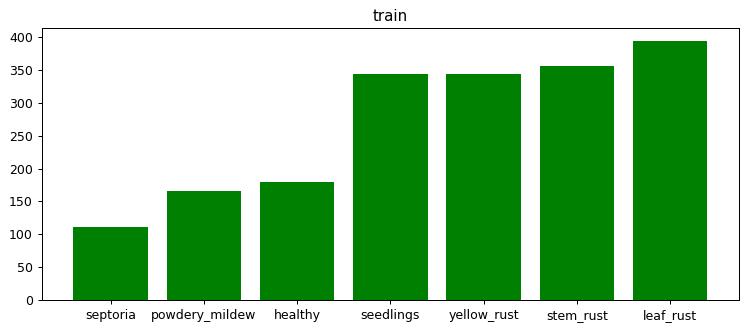

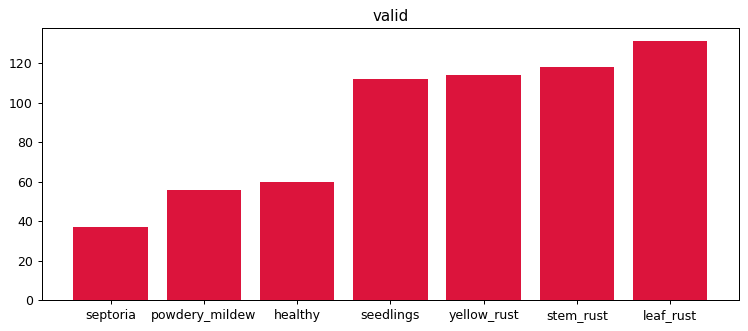

In [3]:
def plot_count(data,name,color=  'blue'):
    fd = data.drop(columns = ['img'])
    t_labels = fd.columns
    cnts = []
    for i in t_labels:
        cnt = (fd[fd[i] == 1]).shape[0]
        cnts.append(cnt)
    
    plt.figure(figsize=  [10,4], dpi = 90)
    
    D = dict(zip(t_labels,cnts))
    D = dict(sorted(D.items(), key=  lambda item: item[1]))
    plt.bar(range(len(D)), list(D.values()), align='center',color= color)
    plt.xticks(range(len(D)), list(D.keys()))
    plt.title(name)
    print("\n\n")
    plt.show()

plot_count(data_train,color = 'green',name = "train")
plot_count(data_valid,color = 'crimson',name = "valid")

In [4]:
data_dir = "/kaggle/input/my-seminar-dataset/wfd_dataset/wfd_dataset/"
NUM_CLASSES = 7
batch_size = 64
IMG_SIZE = (224,224,3)
AUTOTUNE = tf.data.experimental.AUTOTUNE
LR = 1e-4
print(AUTOTUNE)

-1


In [5]:
# Required custom functions

def load_and_preprocess_image(filename):
    ''' Function to load and preprocess image '''
    image = tf.io.read_file((data_dir + filename))
    image = tf.io.decode_image(image,channels = 3,expand_animations = False)
    image = image / 255
    resized_image = tf.image.resize(image,[IMG_SIZE[0],IMG_SIZE[1]])
    return resized_image

def load_from_filename_label(filename,label): return (load_and_preprocess_image(filename),label)

def prepare(dataframe):
    ''' Takes dataframe and prepares dataset '''
    filenames = dataframe.iloc[:,0]
    labels = dataframe.iloc[:,1:]
    ds = tf.data.Dataset.from_tensor_slices((filenames,labels))
    return ds.map(load_from_filename_label)

def configure_for_performance(ds):
    ''' Convert whole dataset into batchs.
        For better internal loading  '''
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

def show(filename):
    ''' displays image based on filename '''
    plt.figure()
    img = cv2.imread(str(data_dir + filename))
    plt.imshow(img)
    plt.show()

def plot(history,metric):
    ''' Plots the model performence '''
    acc = history.history[metric]
    val_acc = history.history[f'val_{metric}']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
            
    plt.figure(figsize=(12,5),dpi = 100)

    plt.subplot(121)
    plt.title(f'Training and Validation {metric}')
    plt.plot(acc, label=f'Training {metric}')
    plt.plot(val_acc, label=f'Validation {metric}')
    plt.legend(loc='lower right')
    plt.ylabel(f"{metric}")
    plt.ylim([min(plt.ylim()),1])
    plt.xlabel('epoch')
    

    plt.subplot(122)
    plt.title('Training and Validation Loss')
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.xlabel('epoch')
    plt.show()
    #     plt.ylim([0,1.0])
    
    

def get_results(model,train_ds,valid_ds):
    train_loss , train_acc = model.evaluate(train_ds,steps = 16)
    valid_loss , valid_acc = model.evaluate(valid_ds,steps = 16)
    results = {
            "train":{
                "acc":train_acc,
                "loss":train_loss
            },
            "validation":{
                "acc":valid_acc,
                "loss":valid_loss
            }
        }
    return results

In [12]:
# Augmentation
# data_aug = Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.2)
# ],
# name = "data augmentation")

# Model Building

## EfficientNet B1

2022-12-05 12:25:19.364654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 12:25:19.467289: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 12:25:19.468064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 12:25:19.470323: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Train set	= 1454 samples
Valid set	= 480  samples
27033600/27018416 [==============================] - 0s 0us/step
Model: "EfficientNetB1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (224, 224, 3)             0         
_________________________________________________________________
random_rotation (RandomRotat (224, 224, 3)             0         
_________________________________________________________________
rescaling_1 (Rescaling)      (224, 224, 3)             0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 7, 7, 1280)        6575239   
_________________________________________________________________
global_average_pooling2d (Gl (1, 1280)                 0         
_________________________________________________________________
batch_normalization (BatchNo (1, 1280)                 5120      
___

2022-12-05 12:25:32.333017: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-05 12:25:43.295951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 173 of 1000
2022-12-05 12:25:53.312305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 345 of 1000
2022-12-05 12:26:03.398178: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 549 of 1000
Cleanup called...
Cleanup called...
2022-12-05 12:26:13.365218: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 738 of 1000
2022-12-05 12:26:23.305384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 931 of 1000
2022-12-05 12:26:26.382464: I tensorflow/core/kernels/data/shuf

23/23 [==============================] - ETA: 0s - loss: 2.9594 - accuracy: 0.1492

2022-12-05 12:27:10.402143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 166 of 1000
2022-12-05 12:27:20.388527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 381 of 1000
2022-12-05 12:27:26.516779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


23/23 [==============================] - 121s 2s/step - loss: 2.9594 - accuracy: 0.1492 - val_loss: 2.5539 - val_accuracy: 0.1792
Epoch 2/30
23/23 [==============================] - 3s 147ms/step - loss: 2.8657 - accuracy: 0.1417 - val_loss: 2.5354 - val_accuracy: 0.1792
Epoch 3/30
23/23 [==============================] - 3s 144ms/step - loss: 2.7863 - accuracy: 0.1568 - val_loss: 2.5219 - val_accuracy: 0.1792
Epoch 4/30
23/23 [==============================] - 3s 145ms/step - loss: 2.7544 - accuracy: 0.1582 - val_loss: 2.5114 - val_accuracy: 0.1792
Epoch 5/30
23/23 [==============================] - 3s 146ms/step - loss: 2.7594 - accuracy: 0.1596 - val_loss: 2.4981 - val_accuracy: 0.1792
Epoch 6/30
23/23 [==============================] - 3s 146ms/step - loss: 2.7807 - accuracy: 0.1609 - val_loss: 2.4898 - val_accuracy: 0.1792
Epoch 7/30
23/23 [==============================] - 3s 145ms/step - loss: 2.7892 - accuracy: 0.1768 - val_loss: 2.4818 - val_accuracy: 0.1750
Epoch 8/30
23/23 [

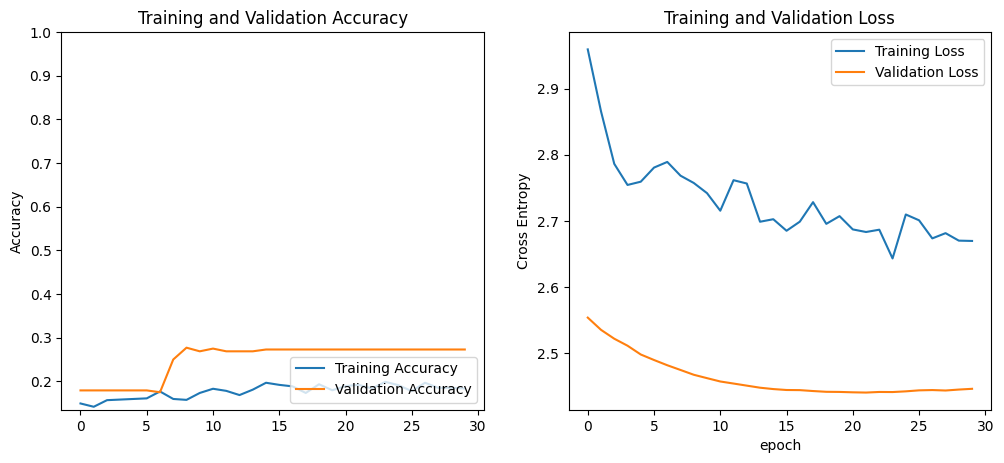


 STARTED TO FINETUNE...

Epoch 31/60
23/23 [==============================] - 36s 762ms/step - loss: 2.9465 - accuracy: 0.2641 - val_loss: 2.5029 - val_accuracy: 0.2729
Epoch 32/60
23/23 [==============================] - 15s 657ms/step - loss: 2.5917 - accuracy: 0.3446 - val_loss: 2.5021 - val_accuracy: 0.2729
Epoch 33/60
23/23 [==============================] - 15s 656ms/step - loss: 2.3757 - accuracy: 0.4230 - val_loss: 2.5233 - val_accuracy: 0.2729
Epoch 34/60
23/23 [==============================] - 15s 660ms/step - loss: 2.3645 - accuracy: 0.4367 - val_loss: 3.3904 - val_accuracy: 0.1792
Epoch 35/60
23/23 [==============================] - 15s 655ms/step - loss: 2.3718 - accuracy: 0.4684 - val_loss: 3.7632 - val_accuracy: 0.1729
Epoch 36/60
23/23 [==============================] - 16s 684ms/step - loss: 2.3800 - accuracy: 0.4856 - val_loss: 4.1165 - val_accuracy: 0.2646
Epoch 37/60
23/23 [==============================] - 15s 659ms/step - loss: 2.6036 - accuracy: 0.5165 - val_lo

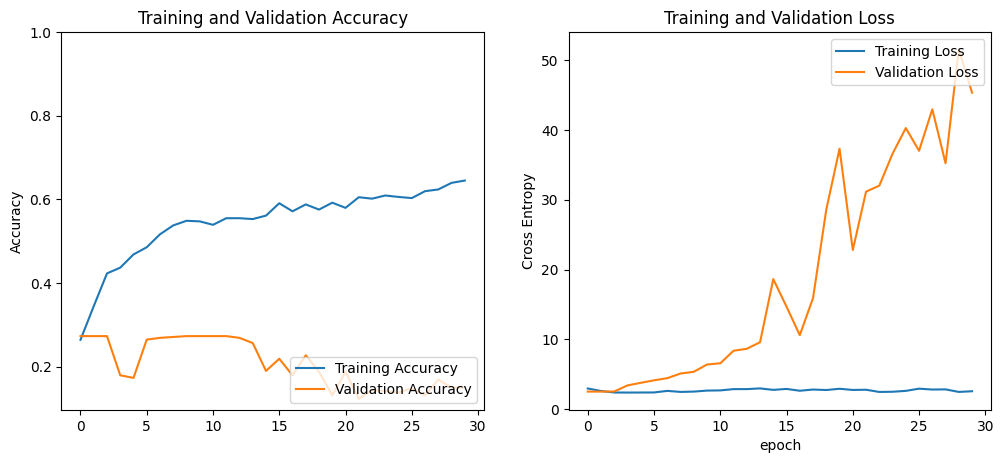

In [6]:
# IMG_SIZE = (224,224,3)
# EPOCHS = 30
# LR = 1e-4

# train_ds = prepare(data_train)
# valid_ds = prepare(data_valid)

# print(f"Train set\t= {train_ds.cardinality().numpy()} samples")
# print(f"Valid set\t= {valid_ds.cardinality().numpy()}  samples")
# # print(f"Test set\t= {test_ds.cardinality().numpy()}  samples")


# train_ds = configure_for_performance(train_ds)
# valid_ds = configure_for_performance(valid_ds)

# # for image_batch, labels_batch in train_ds:
# #     print(image_batch.shape)
# #     print(labels_batch.shape)
# #     break
    

# base_model = EfficientNetB1(input_shape = (IMG_SIZE),include_top = False,weights = 'imagenet')
# base_model.trainable = False

# b1model = Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.2),
#     layers.Rescaling(1./255),
    
#     base_model,
    
#     GlobalAveragePooling2D(),
#     BatchNormalization(),
#     Dropout(0.3),
#     Dense(units = NUM_CLASSES,activation = 'sigmoid',name= 'output_layer')
# ],name = "EfficientNetB1")

# b1model.build(IMG_SIZE)
# b1model.summary()

# Optimizer = tf.keras.optimizers.RMSprop(learning_rate = LR)
# loss = tf.keras.losses.CategoricalCrossentropy()

# b1model.compile(optimizer = Optimizer,loss = loss,metrics=['accuracy'])
# history = b1model.fit(train_ds,validation_data = valid_ds, epochs = EPOCHS)
# plot(history)

# print("\n" + "\033[1;3m STARTED TO FINETUNE...\n")

# #finetune

# base_model.trainable = True
# # fine_tune_at = 290

# # for layer in base_model.layers[:fine_tune_at]:
# #     layer.trainable = False

# b1model.compile(optimizer = Optimizer,loss = loss,metrics=['accuracy'])
# history_fine = b1model.fit(train_ds,validation_data = valid_ds, epochs = EPOCHS + 30,initial_epoch = 30)
# plot(history_fine)

In [8]:
# #################################

# modelName = b1model.name
# b1model.save(f"{modelName}.h5")
# print(f"{modelName} saved ast .h5!")

# with open(f"{modelName}_result.txt","w") as file:
#     file.write(str(get_results(b1model,train_ds,valid_ds)))  
# print(f"{modelName} Results written!")

# print("Done")

EfficientNetB1 Results written!
Done


## InceptionV3

2022-12-05 12:48:51.981695: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 12:48:52.129900: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 12:48:52.130662: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 12:48:52.132936: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 3s 0us/step
Model: "InceotionV3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 150, 150, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 2048)              8192      
________________________________________________________

2022-12-05 12:49:04.129504: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-05 12:49:14.770975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 168 of 1000
2022-12-05 12:49:24.886589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 342 of 1000
Cleanup called...
2022-12-05 12:49:34.793481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 522 of 1000
2022-12-05 12:49:44.849053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 721 of 1000
2022-12-05 12:49:54.775912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 900 of 1000
2022-12-05 12:50:00.454289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:

23/23 [==============================] - ETA: 0s - loss: 3.5594 - accuracy: 0.1451

2022-12-05 12:50:41.130892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 209 of 1000
2022-12-05 12:50:51.148579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 384 of 1000
2022-12-05 12:50:55.713347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


23/23 [==============================] - 116s 2s/step - loss: 3.5594 - accuracy: 0.1451 - val_loss: 2.7315 - val_accuracy: 0.2042
Epoch 2/20
23/23 [==============================] - 1s 65ms/step - loss: 3.3104 - accuracy: 0.1774 - val_loss: 2.6820 - val_accuracy: 0.2313
Epoch 3/20
23/23 [==============================] - 2s 70ms/step - loss: 3.1435 - accuracy: 0.1946 - val_loss: 2.6181 - val_accuracy: 0.2646
Epoch 4/20
23/23 [==============================] - 1s 64ms/step - loss: 3.0864 - accuracy: 0.2125 - val_loss: 2.5861 - val_accuracy: 0.2896
Epoch 5/20
23/23 [==============================] - 1s 65ms/step - loss: 2.9538 - accuracy: 0.2256 - val_loss: 2.5596 - val_accuracy: 0.3042
Epoch 6/20
23/23 [==============================] - 1s 64ms/step - loss: 2.8534 - accuracy: 0.2380 - val_loss: 2.5362 - val_accuracy: 0.3146
Epoch 7/20
23/23 [==============================] - 2s 66ms/step - loss: 2.7812 - accuracy: 0.2586 - val_loss: 2.5013 - val_accuracy: 0.3229
Epoch 8/20
23/23 [======

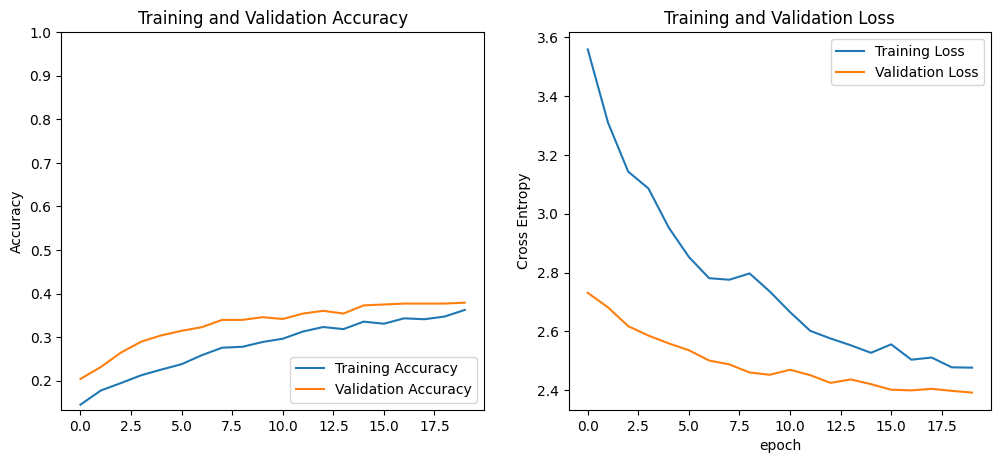

Epoch 21/60
23/23 [==============================] - 17s 225ms/step - loss: 2.7358 - accuracy: 0.3391 - val_loss: 3.6069 - val_accuracy: 0.3896
Epoch 22/60
23/23 [==============================] - 3s 148ms/step - loss: 2.9497 - accuracy: 0.4058 - val_loss: 5.1714 - val_accuracy: 0.3812
Epoch 23/60
23/23 [==============================] - 3s 148ms/step - loss: 3.0540 - accuracy: 0.4491 - val_loss: 6.2288 - val_accuracy: 0.4146
Epoch 24/60
23/23 [==============================] - 3s 150ms/step - loss: 3.0396 - accuracy: 0.4842 - val_loss: 7.4677 - val_accuracy: 0.3979
Epoch 25/60
23/23 [==============================] - 3s 149ms/step - loss: 3.5046 - accuracy: 0.5165 - val_loss: 8.3040 - val_accuracy: 0.4604
Epoch 26/60
23/23 [==============================] - 3s 149ms/step - loss: 3.0937 - accuracy: 0.5193 - val_loss: 5.7594 - val_accuracy: 0.4000
Epoch 27/60
23/23 [==============================] - 3s 148ms/step - loss: 2.8288 - accuracy: 0.5371 - val_loss: 5.3850 - val_accuracy: 0.395

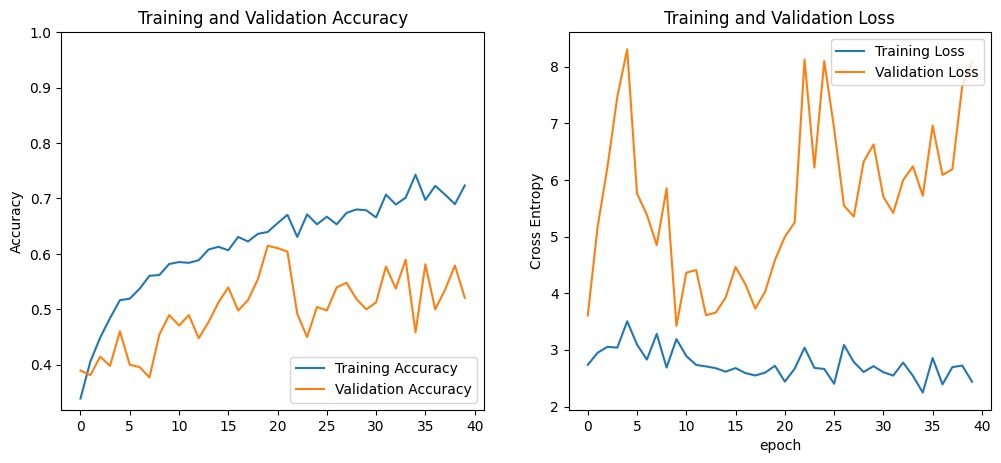

In [8]:
# IMG_SIZE = (150,150,3)
# EPOCHS = 20
# NUM_CLASSES = 7
# LR = 1e-4

# train_ds = prepare(data_train)
# valid_ds = prepare(data_valid)

# train_ds = configure_for_performance(train_ds)
# valid_ds = configure_for_performance(valid_ds)


# base_model = InceptionV3(input_shape = (IMG_SIZE),include_top = False,weights = 'imagenet')
# base_model.trainable = False

# inmodel = Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.2),
#     layers.Rescaling(1./255),
    
#     base_model,
    
#     GlobalAveragePooling2D(),
#     BatchNormalization(),
#     Dropout(0.3),
#     Dense(units = NUM_CLASSES,activation = 'sigmoid',name= 'output_layer')
# ],name = "InceptionV3")


# inmodel.build(((None,) + IMG_SIZE))
# inmodel.summary()

# Optimizer = tf.keras.optimizers.RMSprop(learning_rate = LR)
# loss = tf.keras.losses.CategoricalCrossentropy()

# inmodel.compile(optimizer = Optimizer,loss = loss,metrics=['accuracy'])
# history = inmodel.fit(train_ds,validation_data = valid_ds, epochs = EPOCHS)
# plot(history)


# # print("\n" + "\033[1;3m STARTED TO FINETUNE...\n")


# #finetuning
# base_model.trainable = True

# inmodel.build(((None,) + IMG_SIZE))
# # Optimizer = tf.keras.optimizers.RMSprop(learning_rate = 5e-4)
# # loss = tf.keras.losses.CategoricalCrossentropy()

# inmodel.compile(optimizer = Optimizer,loss = loss,metrics=['accuracy'])
# history_fine = inmodel.fit(train_ds,validation_data = valid_ds, epochs = EPOCHS + 40,initial_epoch = 20)
# plot(history_fine)

In [27]:
# #################################

# modelName = inmodel.name
# inmodel.save(f"{modelName}.h5")
# print(f"{modelName} saved ast .h5!")

# with open(f"{modelName}_result.txt","w") as file:
#     file.write(str(get_results(inmodel,train_ds,valid_ds)))  
# print(f"{modelName} Results written!")

# print("Done")

InceotionV3 saved ast .h5!
16/16 [==============================] - 0s 20ms/step - loss: 8.0858 - accuracy: 0.5208
InceotionV3 Results written!
Result image saved!
Done


<Figure size 432x288 with 0 Axes>

Model: "EfficientNetB1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_1 (RandomFlip)   (None, 150, 150, 3)       0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_189 (Bat (None, 2048)              8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)           

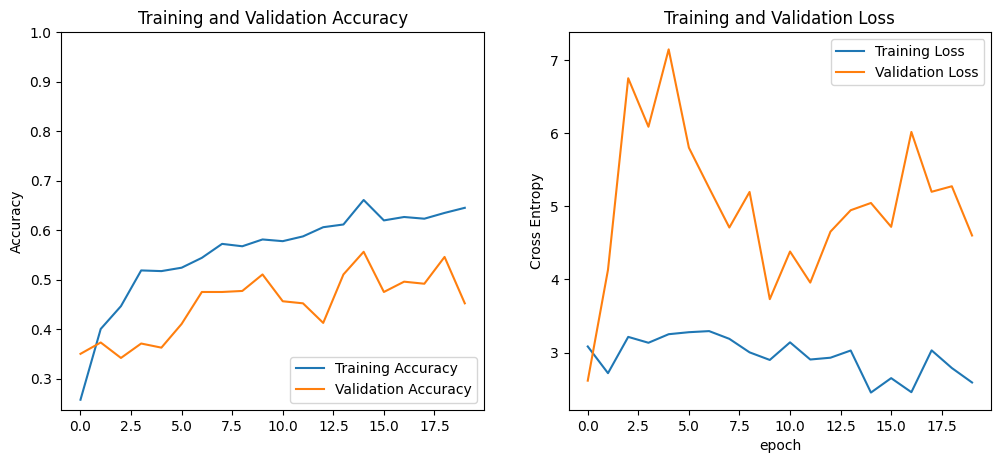

In [35]:
# # inception without finetuning

# # train_ds = prepare(data_train)
# # valid_ds = prepare(data_valid)

# # train_ds = configure_for_performance(train_ds)
# # valid_ds = configure_for_performance(valid_ds)


# base_model = InceptionV3(input_shape = (IMG_SIZE),include_top = False,weights = 'imagenet')
# base_model.trainable = False

# inmodel = Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.2),
#     layers.Rescaling(1./255),
    
#     base_model,
    
#     GlobalAveragePooling2D(),
#     BatchNormalization(),
#     Dropout(0.3),
#     Dense(units = NUM_CLASSES,activation = 'sigmoid',name= 'output_layer')
# ],name = "InceptionV3")


# inmodel.build(((None,) + IMG_SIZE))
# inmodel.summary()

# Optimizer = tf.keras.optimizers.RMSprop(learning_rate = LR)
# loss = tf.keras.losses.CategoricalCrossentropy()

# inmodel.compile(optimizer = Optimizer,loss = loss,metrics=['accuracy'])
# history = inmodel.fit(train_ds,validation_data = valid_ds, epochs = EPOCHS)
# plot(history)

## ResNet50

Model: "ResNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_1 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0  

2022-12-05 13:56:26.535866: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-05 13:56:37.094304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 157 of 1000
Cleanup called...
Cleanup called...
2022-12-05 13:56:47.131258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 346 of 1000
2022-12-05 13:56:57.096679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 541 of 1000
2022-12-05 13:57:07.155540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 714 of 1000
2022-12-05 13:57:17.079914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 916 of 1000
2022-12-05 13:57:21.485605: I tensorflow/core/kernels/data/shuf

23/23 [==============================] - ETA: 0s - loss: 2.7836 - accuracy: 0.1417

2022-12-05 13:58:04.125659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 188 of 1000
2022-12-05 13:58:14.004780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 369 of 1000
2022-12-05 13:58:19.308819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


23/23 [==============================] - 117s 2s/step - loss: 2.7836 - accuracy: 0.1417 - val_loss: 2.9431 - val_accuracy: 0.1792
Epoch 2/20
23/23 [==============================] - 4s 163ms/step - loss: 2.6538 - accuracy: 0.1609 - val_loss: 2.8227 - val_accuracy: 0.1792
Epoch 3/20
23/23 [==============================] - 4s 161ms/step - loss: 2.6175 - accuracy: 0.1816 - val_loss: 2.7358 - val_accuracy: 0.1792
Epoch 4/20
23/23 [==============================] - 4s 163ms/step - loss: 2.5680 - accuracy: 0.1829 - val_loss: 2.6566 - val_accuracy: 0.1792
Epoch 5/20
23/23 [==============================] - 4s 164ms/step - loss: 2.5598 - accuracy: 0.1960 - val_loss: 2.5915 - val_accuracy: 0.1792
Epoch 6/20
23/23 [==============================] - 4s 161ms/step - loss: 2.5153 - accuracy: 0.2201 - val_loss: 2.5462 - val_accuracy: 0.1792
Epoch 7/20
23/23 [==============================] - 4s 160ms/step - loss: 2.4986 - accuracy: 0.2256 - val_loss: 2.5083 - val_accuracy: 0.1792
Epoch 8/20
23/23 [

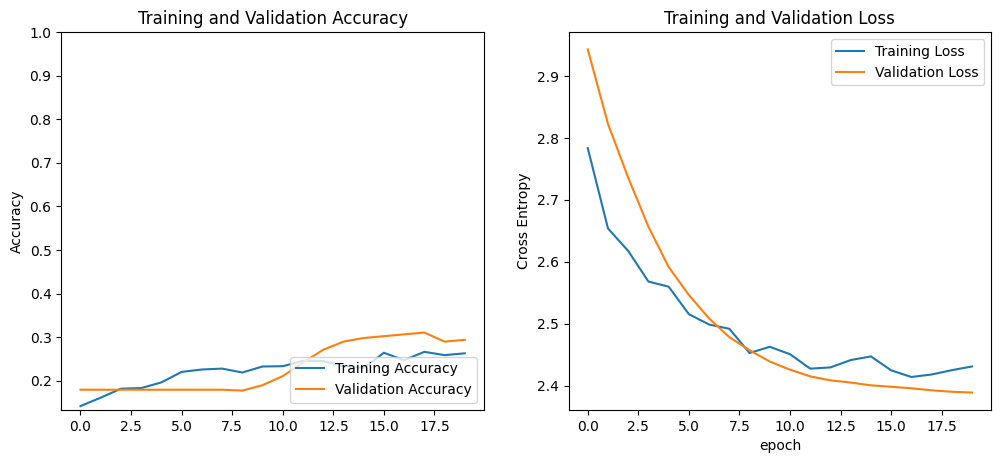

Epoch 21/60
23/23 [==============================] - 21s 443ms/step - loss: 3.0601 - accuracy: 0.3349 - val_loss: 13.4650 - val_accuracy: 0.1312
Epoch 22/60
23/23 [==============================] - 9s 385ms/step - loss: 3.3855 - accuracy: 0.4161 - val_loss: 6.5923 - val_accuracy: 0.1312
Epoch 23/60
23/23 [==============================] - 9s 382ms/step - loss: 3.3537 - accuracy: 0.5206 - val_loss: 15.5744 - val_accuracy: 0.1312
Epoch 24/60
23/23 [==============================] - 9s 382ms/step - loss: 3.2968 - accuracy: 0.5612 - val_loss: 50.7023 - val_accuracy: 0.1312
Epoch 25/60
23/23 [==============================] - 9s 383ms/step - loss: 3.0753 - accuracy: 0.5763 - val_loss: 15.9665 - val_accuracy: 0.1333
Epoch 26/60
23/23 [==============================] - 9s 380ms/step - loss: 3.2866 - accuracy: 0.6052 - val_loss: 27.8851 - val_accuracy: 0.1312
Epoch 27/60
23/23 [==============================] - 9s 383ms/step - loss: 3.3254 - accuracy: 0.5970 - val_loss: 29.4489 - val_accuracy:

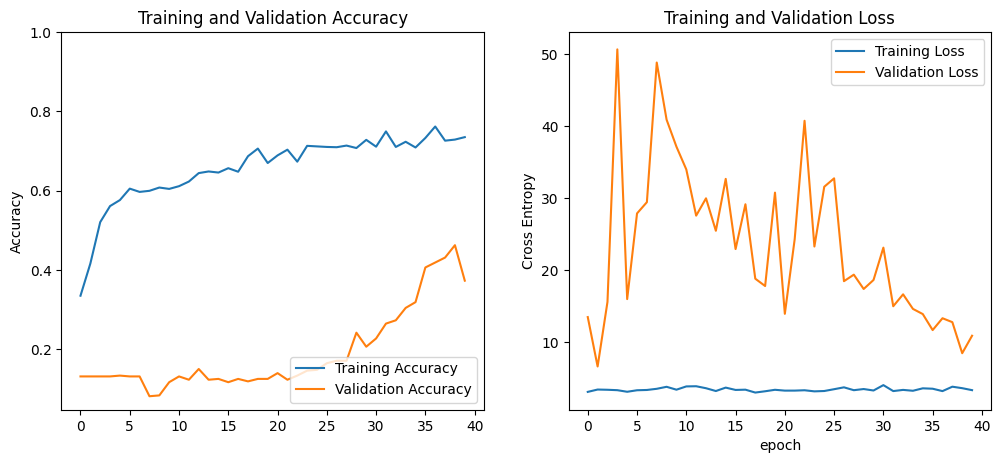

In [8]:
# ResNet50
EPOCHS  = 20
EPOCHS_FT = EPOCHS + 40
# LR = 5e-4

train_ds = prepare(data_train)
valid_ds = prepare(data_valid)

train_ds = configure_for_performance(train_ds)
valid_ds = configure_for_performance(valid_ds)

base_model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")
base_model.trainable = False

resmodel = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.Rescaling(1./255),
    
    base_model,
    
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.4),
    Dense(units = NUM_CLASSES,activation = 'sigmoid',name= 'output_layer')
],name = "ResNet50")


resmodel.build(((None,) + IMG_SIZE))
resmodel.summary()

Optimizer = tf.keras.optimizers.RMSprop(learning_rate = LR)
loss = tf.keras.losses.CategoricalCrossentropy()

resmodel.compile(optimizer = Optimizer,loss = loss,metrics=['accuracy'])
history = resmodel.fit(train_ds,validation_data = valid_ds, epochs = EPOCHS)
plot(history)


#######################
#finetuning resnet50
base_model.trainable = True
resmodel.compile(optimizer = Optimizer,loss = loss,metrics=['accuracy'])
history_ft = resmodel.fit(train_ds,validation_data = valid_ds, epochs = EPOCHS_FT, initial_epoch = EPOCHS)
plot(history_ft)

In [23]:
# history_ft.history

In [24]:
# resmodel.evaluate(train_ds,steps = 16)

In [15]:
#################################

modelName = resmodel.name

with open(f"{modelName}_result.txt","w") as file:
    file.write(str(get_results(resmodel,train_ds,valid_ds)))  
print(f"{modelName} Results written!")

# resmodel.save(f"{modelName}.h5")
# print(f"{modelName} saved ast .h5!")

print("Done")

16/16 [==============================] - 1s 47ms/step - loss: 10.8702 - accuracy: 0.3729
ResNet50 Results written!
Done


# ResNet50V2

2022-12-06 18:51:02.768533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 18:51:02.868242: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 18:51:02.869045: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 18:51:02.871995: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94683136/94668760 [==============================] - 1s 0us/step
##########
0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad

2022-12-06 18:51:11.991553: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-06 18:51:22.917222: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 72 of 1000
2022-12-06 18:51:32.594834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 159 of 1000
2022-12-06 18:51:42.906152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 239 of 1000
2022-12-06 18:51:52.975754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 326 of 1000
2022-12-06 18:52:02.941981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 404 of 1000
2022-12-06 18:52:13.438744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shu

 6/23 [======>.......................] - ETA: 1:56 - loss: 0.7463 - f1_score: 0.3495

Cleanup called...


23/23 [==============================] - ETA: 0s - loss: 0.5739 - f1_score: 0.3737

2022-12-06 18:54:33.319033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 75 of 1000
2022-12-06 18:54:43.459774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 155 of 1000
2022-12-06 18:54:53.661611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 230 of 1000
2022-12-06 18:55:03.208699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 311 of 1000
2022-12-06 18:55:13.253154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 401 of 1000
2022-12-06 18:55:21.199137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


23/23 [==============================] - 254s 5s/step - loss: 0.5739 - f1_score: 0.3737 - val_loss: 35.5050 - val_f1_score: 0.0727
Epoch 2/20
23/23 [==============================] - 4s 192ms/step - loss: 0.4830 - f1_score: 0.4439 - val_loss: 11.9102 - val_f1_score: 0.2421
Epoch 3/20
23/23 [==============================] - 4s 193ms/step - loss: 0.3568 - f1_score: 0.5227 - val_loss: 6.7592 - val_f1_score: 0.2675
Epoch 4/20
23/23 [==============================] - 4s 191ms/step - loss: 0.2936 - f1_score: 0.5928 - val_loss: 1.8379 - val_f1_score: 0.4135
Epoch 5/20
23/23 [==============================] - 4s 194ms/step - loss: 0.2641 - f1_score: 0.6366 - val_loss: 0.8133 - val_f1_score: 0.5269
Epoch 6/20
23/23 [==============================] - 4s 189ms/step - loss: 0.2406 - f1_score: 0.6559 - val_loss: 1.3815 - val_f1_score: 0.4814
Epoch 7/20
23/23 [==============================] - 4s 192ms/step - loss: 0.2281 - f1_score: 0.6770 - val_loss: 0.6691 - val_f1_score: 0.5070
Epoch 8/20
23/23

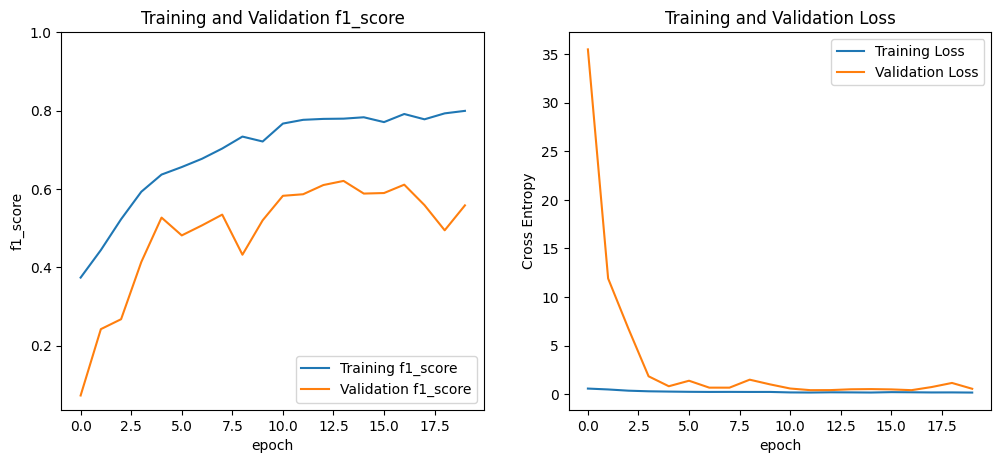

Epoch 21/60
23/23 [==============================] - 17s 482ms/step - loss: 0.2641 - f1_score: 0.6580 - val_loss: 0.3963 - val_f1_score: 0.5919
Epoch 22/60
23/23 [==============================] - 10s 426ms/step - loss: 0.2223 - f1_score: 0.7163 - val_loss: 0.3542 - val_f1_score: 0.5972
Epoch 23/60
23/23 [==============================] - 10s 421ms/step - loss: 0.2053 - f1_score: 0.7266 - val_loss: 0.3364 - val_f1_score: 0.6043
Epoch 24/60
23/23 [==============================] - 10s 421ms/step - loss: 0.1958 - f1_score: 0.7380 - val_loss: 0.3257 - val_f1_score: 0.6096
Epoch 25/60
23/23 [==============================] - 10s 424ms/step - loss: 0.1839 - f1_score: 0.7507 - val_loss: 0.3167 - val_f1_score: 0.6006
Epoch 26/60
23/23 [==============================] - 10s 421ms/step - loss: 0.1840 - f1_score: 0.7450 - val_loss: 0.3127 - val_f1_score: 0.5972
Epoch 27/60
23/23 [==============================] - 10s 422ms/step - loss: 0.1704 - f1_score: 0.7723 - val_loss: 0.3098 - val_f1_score:

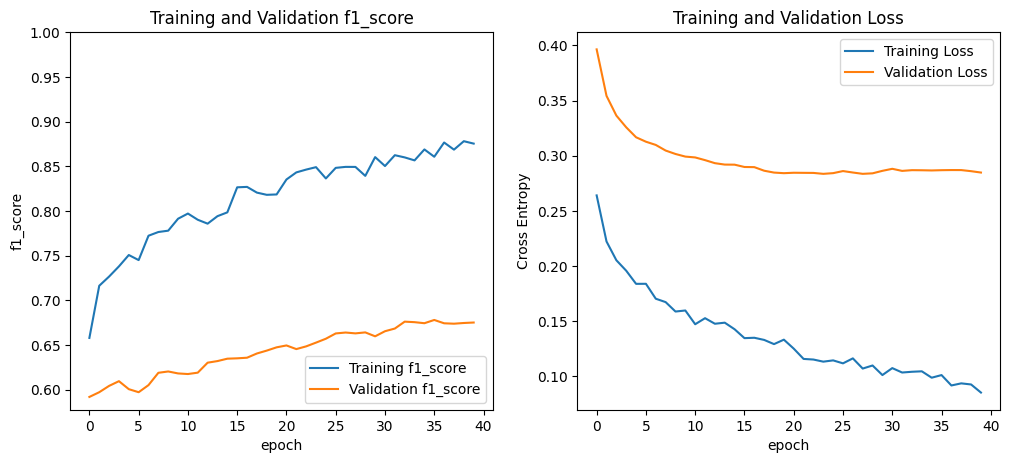

16/16 [==============================] - 2s 126ms/step - loss: 0.0900 - f1_score: 0.8855
[0.09004919975996017, 0.8854662775993347]
16/16 [==============================] - 1s 57ms/step - loss: 0.2848 - f1_score: 0.6752
[0.2847585380077362, 0.6751980185508728]


In [6]:
EPOCHS  = 20
EPOCHS_FT = EPOCHS + 40
IMG_SIZE = (256,256,3)

train_ds = prepare(data_train)
valid_ds = prepare(data_valid)



train_ds = configure_for_performance(train_ds)
valid_ds = configure_for_performance(valid_ds)

base_model = ResNet50V2(input_shape=IMG_SIZE, include_top=False, weights="imagenet")
for layer in base_model.layers[:-11]:
    layer.trainable = False

print("#"*10)
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)
print("#"*10)

augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.4),
    layers.RandomContrast(0.7)
],name="data_augmentation")

resv2model = Sequential([    
    augmentation,
    base_model,
    
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(units = 1024,activation='relu'),
    Dropout(0.4),
    
    Dense(units = NUM_CLASSES, activation = 'sigmoid', name= 'output_layer')
],name = "ResNet50V2")


resv2model.build(((None,) + IMG_SIZE))
resv2model.summary()


######
loss = tf.keras.losses.BinaryCrossentropy()
# accuracy = tf.keras.metrics.Precision(top_k = 3)
f1_score = tfa.metrics.F1Score(num_classes= NUM_CLASSES, average='macro',threshold = 0.25)


es = EarlyStopping(monitor = f1_score, 
                   mode = 'max', 
                   verbose = 1, 
                   patience = 10,
                   restore_best_weights = True)

mc = ModelCheckpoint('best_model.h5',
                     monitor = f1_score, 
                     mode='max',
                     verbose = 1, 
                     save_best_only = True)

callback_list = [es,mc]
######

optimizer = Adam(learning_rate = 5e-3)
resv2model.compile(optimizer,loss ,metrics=[f1_score])
history = resv2model.fit(train_ds,validation_data = valid_ds, epochs = EPOCHS)
plot(history,metric = "f1_score")


#######################
#finetuning resnet
base_model.trainable = True
    
# ft_optimizers = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.0, name="SGD")
ft_optimizers = Adam(learning_rate=7e-6)

resv2model.compile(ft_optimizers, loss,metrics=[f1_score])
history_ft = resv2model.fit(train_ds,validation_data = valid_ds, epochs = EPOCHS_FT, initial_epoch = EPOCHS,callbacks = callback_list)
plot(history_ft,metric = "f1_score")

print(resv2model.evaluate(train_ds,steps = 16))
print(resv2model.evaluate(valid_ds,steps = 16))

In [7]:
resv2model.save("best_model_resnet50V2_tf1_88_vf1_67.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# VGG16

2022-12-06 18:09:24.832041: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 18:09:24.974249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 18:09:24.975360: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 18:09:24.978304: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 2s 0us/step
##########
0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 True
18 block5_pool True
##########
Model: "VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
________________________________________

2022-12-06 18:09:32.123407: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-06 18:09:42.494684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 99 of 1000
2022-12-06 18:09:52.388710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 180 of 1000
2022-12-06 18:10:02.838878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 270 of 1000
2022-12-06 18:10:12.493290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 344 of 1000
2022-12-06 18:10:22.598251: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 423 of 1000
2022-12-06 18:10:32.378855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shu

23/23 [==============================] - ETA: 0s - loss: 0.5827 - f1_score: 0.3446

2022-12-06 18:12:53.096440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 91 of 1000
2022-12-06 18:13:02.984742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 180 of 1000
2022-12-06 18:13:13.200674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 261 of 1000
2022-12-06 18:13:23.057832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 346 of 1000
2022-12-06 18:13:33.009038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 429 of 1000
2022-12-06 18:13:38.092400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


23/23 [==============================] - 251s 5s/step - loss: 0.5827 - f1_score: 0.3446 - val_loss: 5.6448 - val_f1_score: 0.1906
Epoch 2/20
23/23 [==============================] - 4s 172ms/step - loss: 0.4185 - f1_score: 0.3764 - val_loss: 1.8805 - val_f1_score: 0.2720
Epoch 3/20
23/23 [==============================] - 4s 172ms/step - loss: 0.3969 - f1_score: 0.4447 - val_loss: 1.2178 - val_f1_score: 0.2479
Epoch 4/20
23/23 [==============================] - 4s 173ms/step - loss: 0.3783 - f1_score: 0.4591 - val_loss: 0.6054 - val_f1_score: 0.2627
Epoch 5/20
23/23 [==============================] - 4s 173ms/step - loss: 0.3510 - f1_score: 0.4966 - val_loss: 0.8032 - val_f1_score: 0.2849
Epoch 6/20
23/23 [==============================] - 4s 173ms/step - loss: 0.3471 - f1_score: 0.5004 - val_loss: 0.4355 - val_f1_score: 0.4164
Epoch 7/20
23/23 [==============================] - 4s 173ms/step - loss: 0.3198 - f1_score: 0.5353 - val_loss: 1.1314 - val_f1_score: 0.3521
Epoch 8/20
23/23 [

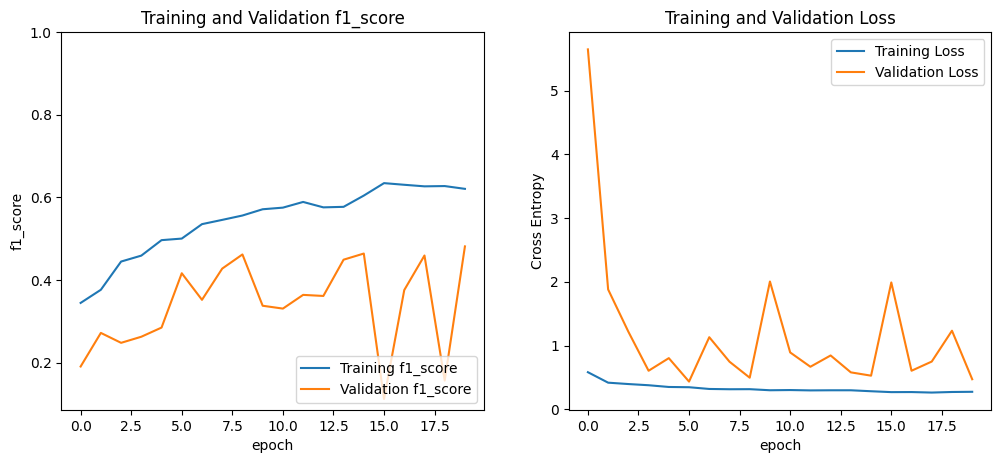

Epoch 21/60
23/23 [==============================] - 15s 508ms/step - loss: 0.2416 - f1_score: 0.6164 - val_loss: 0.3636 - val_f1_score: 0.5542
Epoch 22/60
23/23 [==============================] - 10s 436ms/step - loss: 0.2254 - f1_score: 0.6908 - val_loss: 0.3373 - val_f1_score: 0.5732
Epoch 23/60
23/23 [==============================] - 10s 437ms/step - loss: 0.2193 - f1_score: 0.6929 - val_loss: 0.3069 - val_f1_score: 0.6044
Epoch 24/60
23/23 [==============================] - 10s 434ms/step - loss: 0.2149 - f1_score: 0.6975 - val_loss: 0.3050 - val_f1_score: 0.6040
Epoch 25/60
23/23 [==============================] - 10s 436ms/step - loss: 0.2070 - f1_score: 0.7140 - val_loss: 0.2981 - val_f1_score: 0.6156
Epoch 26/60
23/23 [==============================] - 10s 434ms/step - loss: 0.2044 - f1_score: 0.7180 - val_loss: 0.2887 - val_f1_score: 0.6205
Epoch 27/60
23/23 [==============================] - 10s 438ms/step - loss: 0.2023 - f1_score: 0.7146 - val_loss: 0.2894 - val_f1_score:

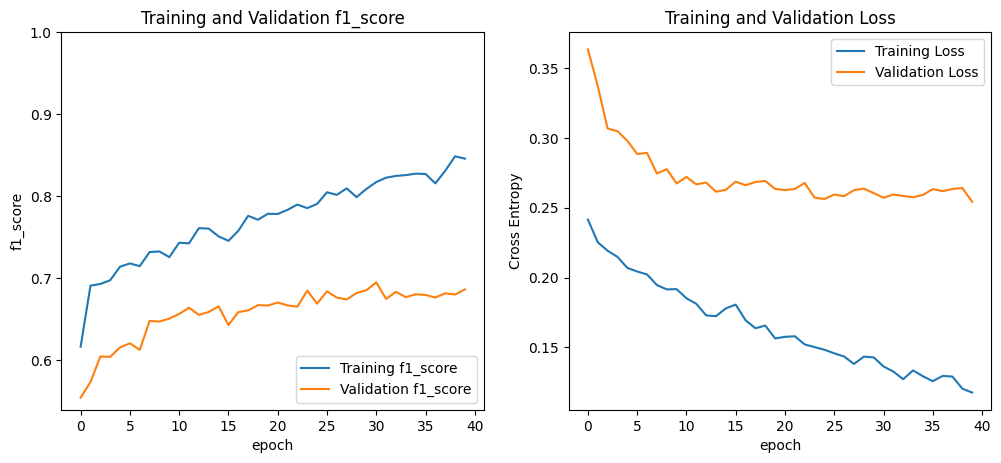

16/16 [==============================] - 2s 124ms/step - loss: 0.1191 - f1_score: 0.8375
[0.11906872689723969, 0.8375006914138794]
16/16 [==============================] - 1s 55ms/step - loss: 0.2544 - f1_score: 0.6863
[0.2543662488460541, 0.6862881779670715]


In [7]:
EPOCHS  = 20
EPOCHS_FT = EPOCHS + 40

train_ds = prepare(data_train)
valid_ds = prepare(data_valid)

train_ds = configure_for_performance(train_ds)
valid_ds = configure_for_performance(valid_ds)

base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
for layer in base_model.layers[:-2]:
    layer.trainable = False

print("#"*10)
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)
print("#"*10)

augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.4),
    layers.RandomContrast(0.7)
],name="data_augmentation")

vggmodel = Sequential([    
    augmentation,
    base_model,
    
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(units = 1024,activation='relu'),
    Dropout(0.4),
    
    Dense(units = NUM_CLASSES, activation = 'sigmoid', name= 'output_layer')
],name = "VGG16")


vggmodel.build(((None,) + IMG_SIZE))
vggmodel.summary()


######
loss = tf.keras.losses.BinaryCrossentropy()
# accuracy = tf.keras.metrics.Precision(top_k = 3)
f1_score = tfa.metrics.F1Score(num_classes= NUM_CLASSES, average='macro',threshold = 0.25)


es = EarlyStopping(monitor = f1_score, 
                   mode = 'max', 
                   verbose = 1, 
                   patience = 10,
                   restore_best_weights = True)

mc = ModelCheckpoint('best_model.h5',
                     monitor = f1_score, 
                     mode='max',
                     verbose = 1, 
                     save_best_only = True)

callback_list = [es,mc]
######

optimizer = Adam(learning_rate = 5e-3)
vggmodel.compile(optimizer,loss ,metrics=[f1_score])
history = vggmodel.fit(train_ds,validation_data = valid_ds, epochs = EPOCHS)
plot(history,metric = "f1_score")


#######################
#finetuning VGG16
base_model.trainable = True
    
# ft_optimizers = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.0, name="SGD")
ft_optimizers = Adam(learning_rate=7e-6)

vggmodel.compile(ft_optimizers, loss,metrics=[f1_score])
history_ft = vggmodel.fit(train_ds,validation_data = valid_ds, epochs = EPOCHS_FT, initial_epoch = EPOCHS,callbacks = callback_list)
plot(history_ft,metric = "f1_score")

print(vggmodel.evaluate(train_ds,steps = 16))
print(vggmodel.evaluate(valid_ds,steps = 16))

In [8]:
# vggmodel.save("best_model_vgg16_tf1_83_vf1_68.h5")

In [38]:
# test_ds = prepare(data_test)
# test_ds
# inmodel.predict(test_ds)

# Extra 

In [ ]:
#Extra 

# def process_path(file_path):
#   label = get_label(file_path)
#   # Load the raw data from the file as a string
#   img = tf.io.read_file(file_path)
#   img = decode_img(img)
#   return img, label

# def decode_img(img):
#   # Convert the compressed string to a 3D uint8 tensor
#   img = tf.io.decode_jpeg(img, channels=3)
#   # Resize the image to the desired size
#   return tf.image.resize(img, [img_height, img_width])


# train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
# val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# Comments #
# plot(history) function
# show(image)
# parse(image)
# getdata()

#efficientNetB1
#inceptionv3
#xception